In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



In [23]:
# Ruta al archivo CSV
file_path = "../data/csv/fomc_sentiment_full.csv"

# Leer CSV 
df = pd.read_csv(file_path, quotechar='"')


In [24]:

# Mostrar las primeras filas
df.head()


,Date,Release Date,Type,Text,Sentiment_Score,Sentiment_Label
0,2025-05-07,2025-05-28,Minute,Minutes of the Federal Open Market Committee\n...,0.9999,positive
1,2025-05-07,2025-05-07,Statement,Although swings in net exports have affected t...,0.6249,positive
2,2025-03-19,2025-03-19,Statement,Recent indicators suggest that economic activi...,0.9306,positive
3,2025-03-19,2025-04-09,Minute,Minutes of the Federal Open Market Committee\n...,0.9998,positive
4,2025-01-29,2025-01-29,Statement,Recent indicators suggest that economic activi...,0.7717,positive


In [25]:
import yfinance as yf
import pandas as pd

# -----------------------------
# CONFIGURACIÓN
# -----------------------------
tickers = ['SAN.MC', 'BBVA.MC']
period = 'max'
interval = '1d'

# -----------------------------
# DESCARGAR DATOS
# -----------------------------
# auto_adjust=False para que Close sea el precio real
data = yf.download(tickers, period=period, interval=interval, auto_adjust=False)

# -----------------------------
# FUNCIONES AUXILIARES
# -----------------------------
def add_features(df):
    # Rango diario
    df['range'] = df['high'] - df['low']
    
    # Retornos diarios
    df['return'] = df['close'].pct_change()
    
    # SMA 5 y 10 días
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['sma_10'] = df['close'].rolling(window=10).mean()
    
    # Volumen relativo (comparado con media de 10 días)
    df['vol_rel'] = df['volume'] / df['volume'].rolling(window=10).mean()
    
    # Solo eliminar filas donde Close sea NaN (no por rolling)
    df = df[df['close'].notna()]
    
    return df

# -----------------------------
# PROCESAR Y GUARDAR POR TICKER
# -----------------------------
for ticker in tickers:
    # Seleccionar columnas de cada ticker usando xs
    df = data.xs(ticker, level=1, axis=1).copy()
    
    # Renombrar columnas a minúsculas
    df.columns = [col.lower() for col in df.columns]
    
    # Añadir features adicionales
    df = add_features(df)
    
    # Guardar CSV
    df.to_csv(f'{ticker.replace(".MC","")}_features.csv')
    print(f'CSV generado: {ticker.replace(".MC","")}_features.csv')


[*********************100%***********************]  2 of 2 completed

CSV generado: SAN_features.csv
CSV generado: BBVA_features.csv


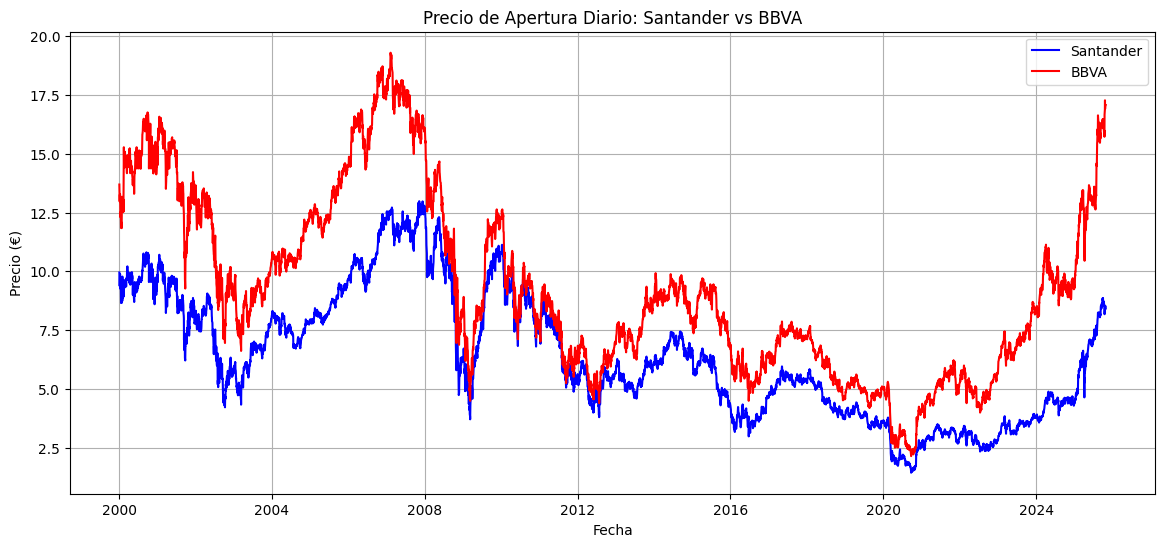

In [26]:
# Cargar CSV
df_san = pd.read_csv('..\data\csv\SAN_features.csv', index_col=0, parse_dates=True)
df_bbva = pd.read_csv('..\data\csv\BBVA_features.csv', index_col=0, parse_dates=True)

# Graficar precio de apertura
plt.figure(figsize=(14,6))
plt.plot(df_san.index, df_san['open'], label='Santander', color='blue')
plt.plot(df_bbva.index, df_bbva['open'], label='BBVA', color='red')

plt.title('Precio de Apertura Diario: Santander vs BBVA')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from datetime import datetime

# ====================================================
# --- 1. Cargar dataset de sentimiento ---
# ====================================================
df_sent = pd.read_csv('../data/csv/fomc_sentiment_extended_recent.csv')

# Normalizar nombres (sin espacios ni mayúsculas)
df_sent.columns = [c.strip().lower() for c in df_sent.columns]

# Detectar la columna de fecha
fecha_cols = [c for c in df_sent.columns if "date" in c]
if not fecha_cols:
    raise ValueError("❌ No se encontró ninguna columna de fecha en el CSV de sentimiento.")
fecha_col = fecha_cols[0]

# Convertir a datetime
df_sent[fecha_col] = pd.to_datetime(df_sent[fecha_col], errors='coerce')
df_sent = df_sent.rename(columns={fecha_col: 'release_date'})

print("✅ Columna de fecha detectada:", fecha_col)
print(df_sent.head())

# ====================================================
# --- 2. Cargar datasets de precios ---
# ====================================================
df_san = pd.read_csv('../data/csv/SAN_features.csv', parse_dates=True, index_col=0)
df_bbva = pd.read_csv('../data/csv/BBVA_features.csv', parse_dates=True, index_col=0)

df_san.index = pd.to_datetime(df_san.index)
df_bbva.index = pd.to_datetime(df_bbva.index)

# ====================================================
# --- 3. Fusionar sentimiento (por fecha más cercana anterior) ---
# ====================================================

def procesar_sentimiento(df_sent, df_price):
    df_sent = df_sent.copy()
    df_price = df_price.copy()

    # Asegurar detección de columnas correctas
    col_label = [c for c in df_sent.columns if "label" in c][0]          # 'sentiment_label'
    col_score = [c for c in df_sent.columns if "score" in c][0]          # 'sentiment_score'
    col_event = [c for c in df_sent.columns if "sentiment_value" in c]   # 'sentiment_value' (ahora detecta mayúsculas)
    col_event = col_event[0] if col_event else None

    # Ordenar por fecha
    df_sent = df_sent.sort_values("release_date").reset_index(drop=True)
    df_price = df_price.sort_index()

    # Inicializar columnas
    df_price["sentiment_score"] = np.nan
    df_price["Sentiment_Numeric"] = np.nan

    j = 0
    for i, date in enumerate(df_price.index):
        # Mover puntero al release_date más reciente <= fecha
        while j + 1 < len(df_sent) and df_sent.loc[j + 1, "release_date"] <= date:
            j += 1

        row = df_sent.loc[j]
        label = str(row.get(col_label, "")).strip().lower()
        score = float(row.get(col_score, 0.0))
        event_val = float(row.get(col_event, np.nan)) if col_event else np.nan

        # --- Fórmula original que tú y yo definimos ---
        if not np.isnan(event_val):        # evento artificial
            value = event_val
        elif label == "positive":
            value = score
        elif label == "negative":
            value = -score
        elif label == "neutral":
            value = (score - 0.5) * 0.3    # leve sesgo neutral
        else:
            value = 0.0

        df_price.loc[date, "sentiment_score"] = score
        df_price.loc[date, "Sentiment_Numeric"] = value

    # Rellenar huecos iniciales
    df_price["sentiment_score"] = df_price["sentiment_score"].ffill().fillna(0)
    df_price["Sentiment_Numeric"] = df_price["Sentiment_Numeric"].ffill().fillna(0)

    return df_price.replace([np.inf, -np.inf], np.nan).fillna(0)


# Aplicar función
df_san = procesar_sentimiento(df_sent, df_san)
df_bbva = procesar_sentimiento(df_sent, df_bbva)

print("✅ Fusión + asignación de sentimiento completada.")
print(df_san[["sentiment_score", "Sentiment_Numeric"]].head(15))

# ====================================================
# --- 4. Escalado conjunto ---
# ====================================================
scaler_san = MinMaxScaler()
features_san_scaled = scaler_san.fit_transform(df_san.values)

scaler_bbva = MinMaxScaler()
features_bbva_scaled = scaler_bbva.fit_transform(df_bbva.values)

print("\n✅ Escalado completado correctamente.")
print("SAN shape:", features_san_scaled.shape)
print("BBVA shape:", features_bbva_scaled.shape)

print(f"\n👉 Rango Sentiment_Numeric SAN: {df_san['Sentiment_Numeric'].min()} → {df_san['Sentiment_Numeric'].max()}")
print(f"👉 Rango Sentiment_Numeric BBVA: {df_bbva['Sentiment_Numeric'].min()} → {df_bbva['Sentiment_Numeric'].max()}")


✅ Columna de fecha detectada: release_date
  release_date sentiment_label  sentiment_score                fuente  \
0   2000-02-02        negative           0.4313             FOMC real   
1   2000-03-10        negative           0.7000  Histórico artificial   
2   2000-03-21         neutral           0.3599             FOMC real   
3   2000-03-23         neutral           0.3668             FOMC real   
4   2000-05-16         neutral           0.3501             FOMC real   

   sentiment_value                      evento  
0              NaN                         NaN  
1             -0.7  Pinchazo burbuja punto-com  
2              NaN                         NaN  
3              NaN                         NaN  
4              NaN                         NaN  
✅ Fusión + asignación de sentimiento completada.
            sentiment_score  Sentiment_Numeric
Date                                          
2000-01-03           0.4313            -0.4313
2000-01-04           0.4313       

In [31]:
# ====================================================
# --- 5. Añadir medias móviles ---
# ====================================================

for df in [df_san, df_bbva]:
    df["MA10"] = df["close"].rolling(window=10).mean()
    df["MA30"] = df["close"].rolling(window=30).mean()
    df["MA60"] = df["close"].rolling(window=60).mean()

# Eliminamos posibles NaN generados al inicio de las medias
df_san = df_san.dropna()
df_bbva = df_bbva.dropna()

print("✅ Medias móviles añadidas correctamente.")
df_san = df_san[[
    'close', 'high', 'low', 'open', 'volume', 'range', 'return',
    'sma_5', 'sma_10', 'vol_rel', 'Sentiment_Numeric', 'MA30', 'MA60'
]]
df_bbva = df_bbva[[
    'close', 'high', 'low', 'open', 'volume', 'range', 'return',
    'sma_5', 'sma_10', 'vol_rel', 'Sentiment_Numeric', 'MA30', 'MA60'
]]


✅ Medias móviles añadidas correctamente.


In [29]:
df_san

,close,high,low,open,volume,range,return,sma_5,sma_10,vol_rel,Sentiment_Numeric,MA30,MA60
Date,,,,,,,,,,,,,
2000-03-24,9.979226,10.065776,9.780161,9.840746,5547595,0.285615,0.013181,10.046735,9.980957,0.351098,-0.03996,9.621198,9.369481
2000-03-27,9.884021,9.979226,9.780161,9.875366,6323555,0.199065,-0.009540,9.972302,10.001729,0.384807,-0.03996,9.650336,9.370058
2000-03-28,10.057121,10.117706,9.823436,9.840746,7847503,0.294271,0.017513,9.958454,10.030291,0.527736,-0.03996,9.680340,9.377415
2000-03-29,9.961916,10.074431,9.875366,9.961916,5076510,0.199065,-0.009466,9.946337,10.041542,0.421874,-0.03996,9.691880,9.387079
2000-03-30,9.832091,9.935951,9.754196,9.866711,8482743,0.181755,-0.013032,9.942875,10.023367,0.755373,-0.03996,9.699381,9.394580
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-22,8.389000,8.473000,8.344000,8.365000,29811260,0.129000,0.002869,8.412800,8.485700,1.062210,-0.04116,8.597167,8.322400
2025-10-23,8.394000,8.474000,8.363000,8.411000,13233829,0.111000,0.000596,8.375800,8.460400,0.473340,-0.04116,8.592267,8.336700
2025-10-24,8.371000,8.468000,8.310000,8.430000,17105426,0.158000,-0.002740,8.391800,8.445500,0.618105,-0.04116,8.588300,8.356300


In [32]:
# ========= Bloque 1: helpers + escalado + ventanas =========
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# 1) Helpers
def find_close_index(df_cols):
    cols_lower = [c.lower() for c in df_cols]
    if "close" not in cols_lower:
        raise ValueError("No encuentro la columna 'Close' en el DataFrame (cámbiala en find_close_index).")
    return cols_lower.index("close")

def create_windowed_dataset(features, target_col_index, window_size=5):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i+window_size])
        y.append(features[i+window_size, target_col_index])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32).reshape(-1, 1)

def inverse_close_from_scaled(pred_scaled_1d, scaler, n_features, close_idx):
    tmp = np.zeros((len(pred_scaled_1d), n_features), dtype=np.float32)
    tmp[:, close_idx] = pred_scaled_1d
    inv = scaler.inverse_transform(tmp)
    return inv[:, close_idx]

# 2) Asegurar índices de fecha y orden
df_san = df_san.sort_index()
df_bbva = df_bbva.sort_index()

# 3) Escalado columna-a-columna (MinMax por feature)
scaler_san = MinMaxScaler()
features_san_scaled = scaler_san.fit_transform(df_san.values)

scaler_bbva = MinMaxScaler()
features_bbva_scaled = scaler_bbva.fit_transform(df_bbva.values)

# 4) Definir target ('Close') e hilo temporal (ventanas)
close_idx_san = find_close_index(df_san.columns)
close_idx_bbva = find_close_index(df_bbva.columns)

WINDOW_SIZE = 5  # puedes subirlo a 10 si quieres más contexto

X_san, y_san = create_windowed_dataset(features_san_scaled, close_idx_san, WINDOW_SIZE)
X_bbva, y_bbva = create_windowed_dataset(features_bbva_scaled, close_idx_bbva, WINDOW_SIZE)

print("SAN -> X:", X_san.shape, "y:", y_san.shape, "| Close idx:", close_idx_san)
print("BBVA -> X:", X_bbva.shape, "y:", y_bbva.shape, "| Close idx:", close_idx_bbva)


SAN -> X: (6509, 5, 13) y: (6509, 1) | Close idx: 0
BBVA -> X: (6509, 5, 13) y: (6509, 1) | Close idx: 0


In [33]:
# ========= Bloque 2: tensores, dataloaders y modelo =========
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)

# Tensores
X_san_t = torch.tensor(X_san, dtype=torch.float32, device=device)
y_san_t = torch.tensor(y_san, dtype=torch.float32, device=device)
X_bbva_t = torch.tensor(X_bbva, dtype=torch.float32, device=device)
y_bbva_t = torch.tensor(y_bbva, dtype=torch.float32, device=device)

# DataLoaders
batch_size = 64
san_loader = DataLoader(TensorDataset(X_san_t, y_san_t), batch_size=batch_size, shuffle=True)
bbva_loader = DataLoader(TensorDataset(X_bbva_t, y_bbva_t), batch_size=batch_size, shuffle=True)

# Modelo
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)          # (B, T, H)
        last = out[:, -1, :]           # (B, H)
        return self.fc(last)           # (B, 1)

input_dim = X_san.shape[2]
model_san = LSTMModel(input_dim).to(device)
model_bbva = LSTMModel(input_dim).to(device)

criterion = nn.MSELoss()
optimizer_san = optim.Adam(model_san.parameters(), lr=0.001)
optimizer_bbva = optim.Adam(model_bbva.parameters(), lr=0.001)


Dispositivo: cuda


In [34]:
# ========= Bloque 3: entrenamiento =========
num_epochs = 500  # puedes subirlo a 600 si no hay overfitting

for epoch in range(1, num_epochs + 1):
    model_san.train(); model_bbva.train()
    epoch_loss_san = 0.0
    epoch_loss_bbva = 0.0

    # SAN
    for xb, yb in san_loader:
        optimizer_san.zero_grad()
        pred = model_san(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer_san.step()
        epoch_loss_san += loss.item() * xb.size(0)

    # BBVA
    for xb, yb in bbva_loader:
        optimizer_bbva.zero_grad()
        pred = model_bbva(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer_bbva.step()
        epoch_loss_bbva += loss.item() * xb.size(0)

    epoch_loss_san /= len(san_loader.dataset)
    epoch_loss_bbva /= len(bbva_loader.dataset)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} | Loss SAN: {epoch_loss_san:.6f} | Loss BBVA: {epoch_loss_bbva:.6f}")


Epoch 10/500 | Loss SAN: 0.000502 | Loss BBVA: 0.000425
Epoch 20/500 | Loss SAN: 0.000331 | Loss BBVA: 0.000316
Epoch 30/500 | Loss SAN: 0.000287 | Loss BBVA: 0.000224
Epoch 40/500 | Loss SAN: 0.000241 | Loss BBVA: 0.000213
Epoch 50/500 | Loss SAN: 0.000225 | Loss BBVA: 0.000201
Epoch 60/500 | Loss SAN: 0.000253 | Loss BBVA: 0.000190
Epoch 70/500 | Loss SAN: 0.000251 | Loss BBVA: 0.000223
Epoch 80/500 | Loss SAN: 0.000209 | Loss BBVA: 0.000181
Epoch 90/500 | Loss SAN: 0.000211 | Loss BBVA: 0.000177
Epoch 100/500 | Loss SAN: 0.000233 | Loss BBVA: 0.000177
Epoch 110/500 | Loss SAN: 0.000223 | Loss BBVA: 0.000166
Epoch 120/500 | Loss SAN: 0.000200 | Loss BBVA: 0.000167
Epoch 130/500 | Loss SAN: 0.000194 | Loss BBVA: 0.000180
Epoch 140/500 | Loss SAN: 0.000205 | Loss BBVA: 0.000166
Epoch 150/500 | Loss SAN: 0.000183 | Loss BBVA: 0.000172
Epoch 160/500 | Loss SAN: 0.000196 | Loss BBVA: 0.000161
Epoch 170/500 | Loss SAN: 0.000202 | Loss BBVA: 0.000166
Epoch 180/500 | Loss SAN: 0.000196 | Los

C:\Users\josit\AppData\Local\Temp\ipykernel_25340\1429210880.py:72: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso02_Prediccion_BBVA_SANTANDER\env11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


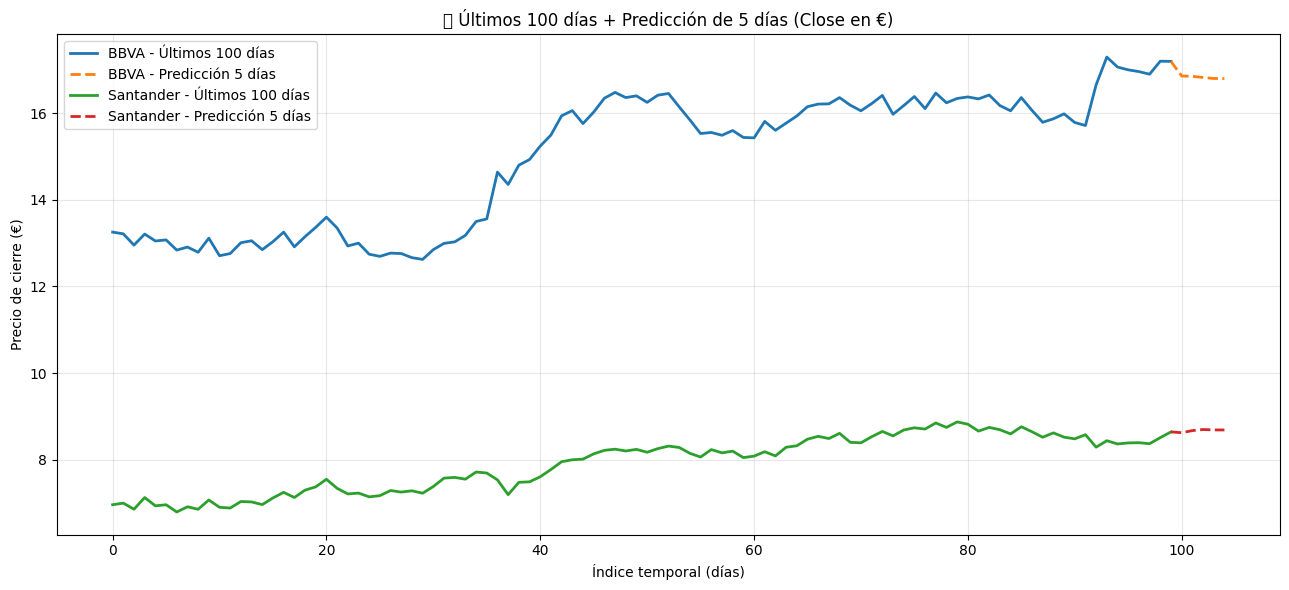

📈 Predicciones para los próximos 5 días:
  Fecha_BBVA  Pred_BBVA (€)  Fecha_SAN  Pred_SAN (€)
0 2025-10-29      16.858999 2025-10-29         8.625
1 2025-10-30      16.850000 2025-10-30         8.673
2 2025-10-31      16.825001 2025-10-31         8.698
3 2025-11-03      16.801001 2025-11-03         8.689
4 2025-11-04      16.799000 2025-11-04         8.688


In [35]:
# ========= Bloque 4: predicción +5, desescalado y gráfica =========
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
import pandas as pd

@torch.no_grad()
def predict_future(model, feat_scaled, window_size, close_idx, device):
    """
    Predicción autorregresiva de 5 pasos en ESCALA ESCALADA (0-1).
    """
    model.eval()
    last_window = torch.tensor(
        feat_scaled[-window_size:], dtype=torch.float32, device=device
    ).unsqueeze(0)  # (1, T, F)

    preds = []
    for _ in range(5):
        out = model(last_window)                 # (1,1)
        pred_close_scaled = out.item()
        preds.append(pred_close_scaled)

        # Nueva fila = copia último día + sustituir close por predicho
        new_row = last_window[:, -1, :].clone()
        new_row[:, close_idx] = pred_close_scaled
        last_window = torch.cat([last_window[:, 1:, :], new_row.unsqueeze(1)], dim=1)

    return np.array(preds, dtype=np.float32)

# 1) Predicciones en escala escalada
pred_bbva_scaled = predict_future(model_bbva, features_bbva_scaled, WINDOW_SIZE, close_idx_bbva, device)
pred_san_scaled  = predict_future(model_san,  features_san_scaled,  WINDOW_SIZE, close_idx_san,  device)

# 2) Desescalar a euros
nfeat_bbva = features_bbva_scaled.shape[1]
nfeat_san  = features_san_scaled.shape[1]

pred_bbva_eur = inverse_close_from_scaled(pred_bbva_scaled, scaler_bbva, nfeat_bbva, close_idx_bbva)
pred_san_eur  = inverse_close_from_scaled(pred_san_scaled,  scaler_san,  nfeat_san,  close_idx_san)

# 3) Últimos 100 reales (en euros) + fechas futuras hábiles
real_bbva_eur = df_bbva.iloc[-100:, close_idx_bbva].to_numpy(dtype=float)
real_san_eur  = df_san.iloc[-100:,  close_idx_san].to_numpy(dtype=float)

last_date_bbva = pd.to_datetime(df_bbva.index).max()
last_date_san  = pd.to_datetime(df_san.index).max()

future_dates_bbva = pd.bdate_range(start=last_date_bbva + BDay(1), periods=5)
future_dates_san  = pd.bdate_range(start=last_date_san  + BDay(1), periods=5)

# 4) Gráfica (cada serie con su predicción pegada)
plt.figure(figsize=(13, 6))

# BBVA
x_real_bbva = np.arange(100)
x_pred_bbva = np.arange(99, 105)
plt.plot(x_real_bbva, real_bbva_eur, label="BBVA - Últimos 100 días", linewidth=2)
plt.plot(x_pred_bbva, np.concatenate([[real_bbva_eur[-1]], pred_bbva_eur]),
         "--", label="BBVA - Predicción 5 días", linewidth=2)

# SAN
x_real_san = np.arange(100)
x_pred_san = np.arange(99, 105)
plt.plot(x_real_san, real_san_eur, label="Santander - Últimos 100 días", linewidth=2)
plt.plot(x_pred_san, np.concatenate([[real_san_eur[-1]], pred_san_eur]),
         "--", label="Santander - Predicción 5 días", linewidth=2)

plt.title("📊 Últimos 100 días + Predicción de 5 días (Close en €)")
plt.xlabel("Índice temporal (días)")
plt.ylabel("Precio de cierre (€)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 5) Tabla con valores predichos
df_pred = pd.DataFrame({
    "Fecha_BBVA": future_dates_bbva,
    "Pred_BBVA (€)": np.round(pred_bbva_eur, 3),
    "Fecha_SAN": future_dates_san,
    "Pred_SAN (€)": np.round(pred_san_eur, 3)
})
print("📈 Predicciones para los próximos 5 días:")
print(df_pred)


📈 Predicciones simuladas según sentimiento (en €):
   Sentiment_Value                       Predicciones_5_Días
0             -5.0  [16.293, 16.211, 16.141, 16.125, 16.125]
1             -2.5  [16.766, 16.696, 16.673, 16.673, 16.678]
2              0.0   [16.888, 16.885, 16.866, 16.859, 16.86]
3              2.5   [16.999, 16.956, 16.94, 16.875, 16.879]
4              5.0   [17.448, 17.463, 17.49, 17.462, 17.477]


C:\Users\josit\AppData\Local\Temp\ipykernel_25340\1467098993.py:81: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso02_Prediccion_BBVA_SANTANDER\env11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


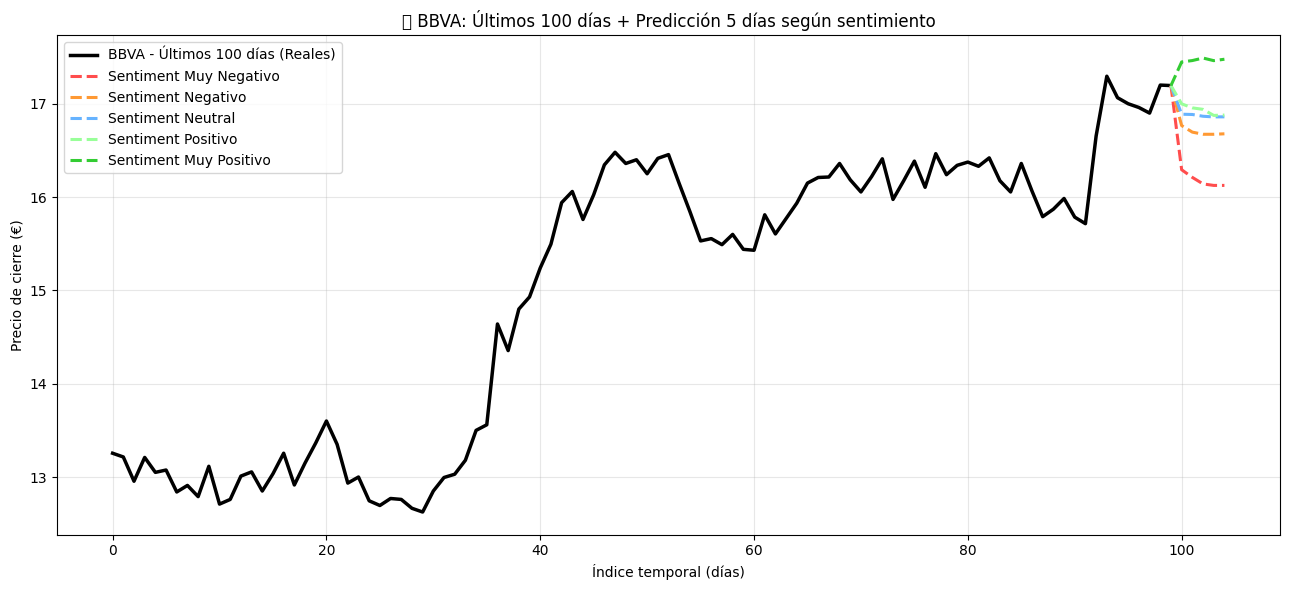

In [36]:
# ========= Bloque 5: simulación por umbrales de sentimiento =========
sentiment_thresholds = [-5.0, -2.5, 0.0, 2.5, 5.0]
results = []

@torch.no_grad()
def predict_with_sentiment(model, features_scaled, window_size, close_idx, sent_idx, sentiment_value, device):
    """
    Simula predicciones modificando el sentimiento en la última ventana.
    """
    model.eval()

    # Copiamos la última ventana
    last_window = torch.tensor(features_scaled[-window_size:], dtype=torch.float32, device=device).unsqueeze(0)

    # Sustituimos la última columna (sentimiento) por el valor forzado
    last_window[:, :, sent_idx] = sentiment_value

    preds_scaled = []
    for _ in range(5):
        out = model(last_window)
        pred_scaled = out.item()
        preds_scaled.append(pred_scaled)

        # Crear nueva fila y desplazar ventana
        new_row = last_window[:, -1, :].clone()
        new_row[:, close_idx] = pred_scaled
        new_row[:, sent_idx] = sentiment_value  # mantener el mismo sentimiento
        last_window = torch.cat([last_window[:, 1:, :], new_row.unsqueeze(1)], dim=1)

    return np.array(preds_scaled, dtype=np.float32)


# 1️⃣ Identificar índice del sentimiento
sent_idx_bbva = [i for i, c in enumerate(df_bbva.columns) if "sentiment_numeric" in c.lower()][0]
sent_idx_san  = [i for i, c in enumerate(df_san.columns)  if "sentiment_numeric" in c.lower()][0]

# 2️⃣ Simular cada umbral
for val in sentiment_thresholds:
    preds_scaled = predict_with_sentiment(model_bbva, features_bbva_scaled, WINDOW_SIZE, close_idx_bbva, sent_idx_bbva, val, device)
    preds_eur = inverse_close_from_scaled(preds_scaled, scaler_bbva, features_bbva_scaled.shape[1], close_idx_bbva)
    results.append((val, np.round(preds_eur, 3)))

# 3️⃣ Mostrar resultados
df_sim = pd.DataFrame(results, columns=["Sentiment_Value", "Predicciones_5_Días"])
print("📈 Predicciones simuladas según sentimiento (en €):")
print(df_sim)

# ========= Bloque 6: últimos 100 días + simulaciones de sentimiento =========
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

# --- 1️⃣ Obtener últimos 100 días reales ---
real_bbva_eur = df_bbva.iloc[-100:, close_idx_bbva].to_numpy(dtype=float)
last_date_bbva = pd.to_datetime(df_bbva.index).max()
future_dates_bbva = pd.bdate_range(start=last_date_bbva + BDay(1), periods=5)
sentimientos = ["Muy Negativo", "Negativo", "Neutral", "Positivo", "Muy Positivo"]
# --- 2️⃣ Colores y labels para las simulaciones ---
colors = ["#ff4d4d", "#ff9933", "#66b3ff", "#99ff99", "#33cc33"]
labels = [f"Sentiment {v:+.1f}" for v in sentiment_thresholds]
labels = [f"Sentiment {v}" for v in sentimientos]
# --- 3️⃣ Gráfica ---
plt.figure(figsize=(13, 6))

# Parte real
x_real = np.arange(len(real_bbva_eur))
plt.plot(x_real, real_bbva_eur, color="black", linewidth=2.5, label="BBVA - Últimos 100 días (Reales)")

# Simulaciones (cada una continúa desde el último punto real)
for i, (val, preds) in enumerate(results):
    x_pred = np.arange(len(real_bbva_eur)-1, len(real_bbva_eur)-1 + len(preds) + 1)
    y_pred = np.concatenate([[real_bbva_eur[-1]], preds])
    labels = [f"Sentiment {v}" for v in sentimientos]
    plt.plot(x_pred, y_pred, "--", linewidth=2.2, color=colors[i], label=labels[i])

# --- 4️⃣ Formato ---
plt.title("📊 BBVA: Últimos 100 días + Predicción 5 días según sentimiento")
plt.xlabel("Índice temporal (días)")
plt.ylabel("Precio de cierre (€)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [37]:
# ========= Bloque 7: tabla de posibles futuros precios según sentimiento =========
import pandas as pd
from pandas.tseries.offsets import BDay

# Crear fechas hábiles futuras (5 días)
last_date_bbva = pd.to_datetime(df_bbva.index).max()
future_dates = pd.bdate_range(start=last_date_bbva + BDay(1), periods=5)

# Construir DataFrame
tabla_predicciones = pd.DataFrame({"Fecha": future_dates})

# Añadir columnas con las predicciones de cada sentimiento
for val, preds in results:
    col_name = f"Sentiment {val:+.1f}"
    tabla_predicciones[col_name] = np.round(preds, 3)

# Reordenar columnas
tabla_predicciones = tabla_predicciones[["Fecha"] + [f"Sentiment {v:+.1f}" for v in sentiment_thresholds]]

# Mostrar tabla con formato y gradiente de color
print("📊 Posibles precios futuros del BBVA según el sentimiento:")
display(
    tabla_predicciones.style
        .background_gradient(cmap="RdYlGn", axis=1)
        .format(precision=3)
)


📊 Posibles precios futuros del BBVA según el sentimiento:


,Fecha,Sentiment -5.0,Sentiment -2.5,Sentiment +0.0,Sentiment +2.5,Sentiment +5.0
0,2025-10-29 00:00:00,16.293,16.766,16.888,16.999,17.448
1,2025-10-30 00:00:00,16.211,16.696,16.885,16.956,17.463
2,2025-10-31 00:00:00,16.141,16.673,16.866,16.940,17.490
3,2025-11-03 00:00:00,16.125,16.673,16.859,16.875,17.462
4,2025-11-04 00:00:00,16.125,16.678,16.860,16.879,17.477
